# Выпускной проект в области "Телеком"

Наша задача - на основе информации о клиентах научиться прогнозировать, кто из клиентов перестанет пользоваться нашими услугами.

1. [Загрузка данных и EDA.](#eda)<br>
    1.1. [Загрузка данных](#loading)<br>
    1.2. [Объединение данных](#merging)  
    1.3. [Анализ распределений значений признаков](#analysis)   
2. [Создание моделей](#ML)  
    2.1. [Подготовка данных](#preparing)  
    2.2. [Константная модель](#dummy)  
    2.3. [DecisionTree, RandomForest и LogisticRegression](#3models)<br>
    2.4. [CatBoost и LightGBM](#boosting)
3. [Выводы](#conclusions)

<a id="eda"></a>
## Шаг 1. Загрузка данных и EDA.

<a id="loading"></a>
### 1.1. Загрузка данных.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [3]:
personal = pd.read_csv('/datasets/final_provider/personal.csv')
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [4]:
internet = pd.read_csv('/datasets/final_provider/internet.csv')
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [5]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<a id="merging"></a>
### 1.2. Объединение данных.

In [6]:
users = contract.merge(personal, on='customerID', how='outer')
users = users.merge(internet, on='customerID', how='outer')
users = users.merge(phone, on='customerID', how='outer')
users = users.drop('customerID', axis=1) # id клиента нам больше не понадобится
users.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
dtypes: float64(1), int64(1), object(17)
memory usage: 1.1+ MB


Поправим форматы.

In [8]:
users['TotalCharges'] = users['TotalCharges'].replace(' ', 0)
users['TotalCharges'] = users['TotalCharges'].astype(float)
users['BeginDate'] = pd.to_datetime(users['BeginDate'])

Заменим разнообразные маркеры оттока клиента на единый и переведем классификацию оттока "да/нет" в 0/1.

In [9]:
users['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

In [10]:
for i in ['2019-12-01 00:00:00', '2019-11-01 00:00:00', '2019-10-01 00:00:00', '2020-01-01 00:00:00']:
    users['EndDate'] = users['EndDate'].replace(i, 1)
users['EndDate'] = users['EndDate'].replace('No', 0)

In [11]:
users.isna().mean()

BeginDate           0.000000
EndDate             0.000000
Type                0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.000000
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
InternetService     0.216669
OnlineSecurity      0.216669
OnlineBackup        0.216669
DeviceProtection    0.216669
TechSupport         0.216669
StreamingTV         0.216669
StreamingMovies     0.216669
MultipleLines       0.096834
dtype: float64

#### Вывод: 
в части признаков пропусков довольно много, больше 20 %. Попробуем далее их заполнить.

Большинство наших признаков категориальные, поэтому матрицу мультиколлинеарности признаков строить не будем.

In [12]:
users.describe()

,EndDate,MonthlyCharges,TotalCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.265370,64.761692,2279.734304,0.162147
std,0.441561,30.090047,2266.794470,0.368612
min,0.000000,18.250000,0.000000,0.000000
25%,0.000000,35.500000,398.550000,0.000000
50%,0.000000,70.350000,1394.550000,0.000000
75%,1.000000,89.850000,3786.600000,0.000000
max,1.000000,118.750000,8684.800000,1.000000


<a id="analysis"></a>
### 1.3. Анализ распределений значений признаков.

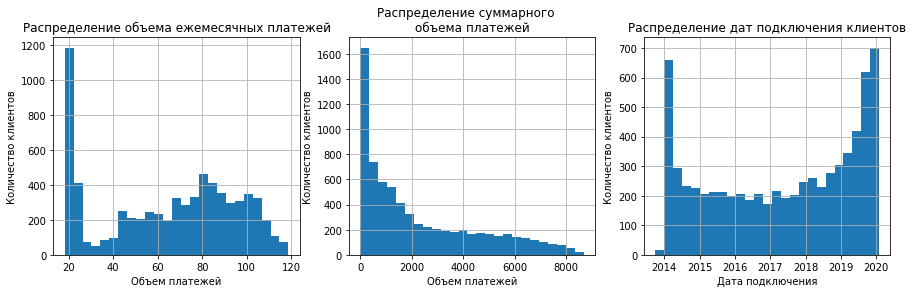

In [13]:
fig = plt.figure(figsize=(15, 4))
area = fig.add_subplot(1, 3, 1)
users['MonthlyCharges'].hist(bins=25)
plt.xlabel('Объем платежей')
plt.ylabel('Количество клиентов')
plt.title('Распределение объема ежемесячных платежей')

area = fig.add_subplot(1, 3, 2)
users['TotalCharges'].hist(bins=25)
plt.xlabel('Объем платежей')
plt.ylabel('Количество клиентов')
plt.title('Распределение суммарного   \nобъема платежей')

area = fig.add_subplot(1, 3, 3)
users['BeginDate'].hist(bins=25)
plt.xlabel('Дата подключения')
plt.ylabel('Количество клиентов')
plt.title('Распределение дат подключения клиентов')
plt.show()

#### Выводы:

1. Чаще всего клиенты платят около 20 у.е. в месяц. Также заметен пик на 80 у.е.
2. Значительное число клиентов заплатило за все время не более 1500 у.е.
3. Пики количества подключений - самое начало наблюдений (2014 г.) и текущий момент. В промежутке количество новых подключений было меньше и в целом оно не менялось год от года.

На примере нескольких графиков убедимся, что 80 у.е. - своего рода водораздел, и те, кто платят больше 80 - пользуются доп.услугами, а те, кто меньше - как правило, нет.

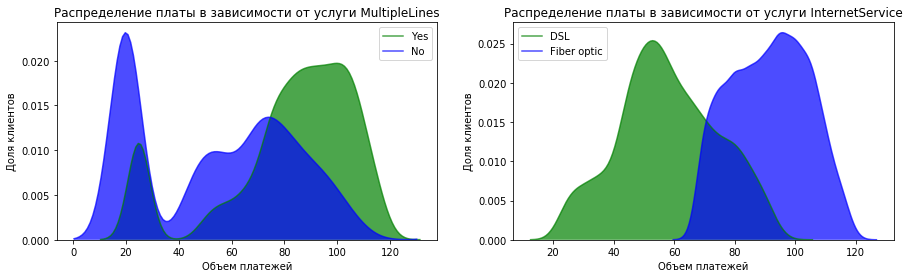

In [14]:
fig = plt.figure(figsize=(15, 4))
area = fig.add_subplot(1, 2, 1)

sns.kdeplot(users.loc[users['MultipleLines'] == 'Yes', "MonthlyCharges"], shade=True, color="green", label="Yes", alpha=.7)
sns.kdeplot(users.loc[users['MultipleLines'] == 'No', "MonthlyCharges"], shade=True, color="blue", label="No", alpha=.7)
plt.title('Распределение платы в зависимости от услуги MultipleLines', fontsize=12)
plt.xlabel('Объем платежей')
plt.ylabel('Доля клиентов')
plt.legend()

area = fig.add_subplot(1, 2, 2)
sns.kdeplot(users.loc[users['InternetService'] == 'DSL', "MonthlyCharges"], shade=True, color="green", label="DSL", alpha=.7)
sns.kdeplot(users.loc[users['InternetService'] == 'Fiber optic', "MonthlyCharges"], shade=True, color="blue", label="Fiber optiс", alpha=.7)
plt.xlabel('Объем платежей')
plt.ylabel('Доля клиентов')
plt.title('Распределение платы в зависимости от услуги InternetService', fontsize=12)
plt.legend()
plt.show()

Добавим дополнительный фактор в зависимости от объема трат, а также заполним пропуски в услугах отрицательными значениями, а пропуск признака InternetService - более дешевым вариантом (DSL)

In [15]:
for i in ['PaperlessBilling', 'Dependents', 'OnlineSecurity', 'OnlineBackup',
        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
        'MultipleLines']:
    users[i] = users[i].fillna('No')

In [16]:
users['InternetService'] = users['InternetService'].fillna('DSL')

In [17]:
users['Status'] = np.where(users['MonthlyCharges']>80, 'Advanced', 'Standard')

Преобразуем дату подключений в число дней в сети.

In [18]:
users['Time'] = (users['BeginDate'].max() - users['BeginDate']).dt.days
users = users.drop('BeginDate', axis=1)
users.head()

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Status,Time
0,0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,Standard,31
1,0,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,Standard,1036
2,1,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,Standard,123
3,0,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,Standard,1371
4,1,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,Standard,153


Проверим количественные признаки на мультиколлинеарность.

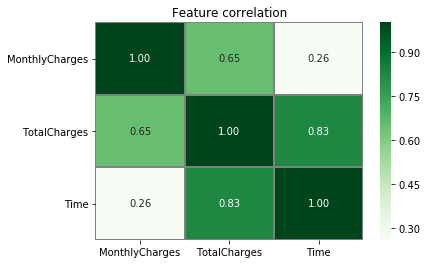

In [19]:
numeric = ['MonthlyCharges', 'TotalCharges', 'Time']
cm = users[numeric].corr()
plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap="Greens")
ax.set_title('Feature correlation')
plt.show()

Видим заметную зависимость между TotalCharges и Time, однако не настолько большую, чтобы смело удалить один из этих признаков.

Оценим распределения категориальных признаков.

In [20]:
for i in ['Type', 'PaperlessBilling', 'PaymentMethod',
       'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines']:

    distr = users[i].value_counts(normalize=True)
    print(distr)
    print()

Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: Type, dtype: float64

Yes    0.592219
No     0.407781
Name: PaperlessBilling, dtype: float64

Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: PaymentMethod, dtype: float64

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64

No     0.516967
Yes    0.483033
Name: Partner, dtype: float64

No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64

DSL            0.560415
Fiber optic    0.439585
Name: InternetService, dtype: float64

No     0.713332
Yes    0.286668
Name: OnlineSecurity, dtype: float64

No     0.655119
Yes    0.344881
Name: OnlineBackup, dtype: float64

No     0.656112
Yes    0.343888
Name: DeviceProtection, dtype: float64

No     0.709783
Yes    0.290217
Name: TechSupport, dtype: float64

No  

#### Выводы:

- количество женщин примерно равно количеству мужчин
- пенсионеров в 5 раз меньше, чем молодых
- дополнительными услугами, как правило, пользуется 30-40% от общего числа клиентов
- 55% клиентов предпочитает помесячный платеж
- все 4 метода платежа пользуются популярностью

In [21]:
users['EndDate'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: EndDate, dtype: float64

#### Вывод

В целевой переменной - дисбаланс классов. Лишь четверть клиентов покинула компанию.

<a id="ML"></a>
## Шаг 2. Создание моделей.

<a id="preparing"></a>
### 2.1. Подготовка данных.

In [22]:
X = users.drop('EndDate', axis=1)
y = users['EndDate']

In [23]:
X = pd.get_dummies(X, drop_first=True)
X.head()

,MonthlyCharges,TotalCharges,SeniorCitizen,Time,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,Status_Standard
0,29.85,29.85,0,31,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1
1,56.95,1889.50,0,1036,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,1
2,53.85,108.15,0,123,0,0,1,0,0,1,...,0,0,1,1,0,0,0,0,0,1
3,42.30,1840.75,0,1371,1,0,0,0,0,0,...,0,0,1,0,1,1,0,0,0,1
4,70.70,151.65,0,153,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [25]:
scaler = StandardScaler()
scaler.fit(X_train[numeric])

X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

<a id="dummy"></a>
### 2.2.Константная модель.

In [26]:
dummy = DummyClassifier(strategy='stratified', random_state=1)
dummy.fit(X_train, y_train)
predictions = dummy.predict(X_test)
roc_auc = roc_auc_score(y_test, predictions)
print("ROC-AUC = {:.3f}".format(roc_auc))  

ROC-AUC = 0.501


<a id="3models"></a>
### 2.3. DecisionTree, RandomForest и LogisticRegression.

In [27]:
# создадим функции, которые будут выводить целевую метрику для моделей DecisionTree, RandomForest и LogisticRegression
# в обеих функциях будет учитываться порог разбиения целевой переменной по классам
# при этом для DecisionTree и RandomForest будут подобраны гиперпараметры при помощи RandomizedSearchCV
param_tree = {'max_depth': range(5, 51, 5), 'min_samples_split': range(2, 10), 'min_samples_leaf': range(1, 10)}
param_forest = {'n_estimators': range(10, 101, 10)}

def model_with_randomizedsearchcv_threshold(searcher, features, target):
    searcher.fit(features, target)
    best_model = searcher.best_estimator_
    probabilities_test = best_model.predict_proba(X_test)
    probabilities_one_test = probabilities_test[:, 1]
    
    for threshold in np.arange(0.3, 0.51, 0.05):
        predicted_test = probabilities_one_test > threshold
        roc_auc = roc_auc_score(y_test, predicted_test)
        print("Порог = {:.2f} | ROC-AUC = {:.3f}".format(threshold, roc_auc))

def model_threshold(model, features, target):
    model.fit(features, target)
    probabilities_test = model.predict_proba(X_test)
    probabilities_one_test = probabilities_test[:, 1]
    
    for threshold in np.arange(0.3, 0.51, 0.05):
        predicted_test = probabilities_one_test > threshold
        roc_auc = roc_auc_score(y_test, predicted_test)
        print("Порог = {:.2f} | ROC-AUC = {:.3f}".format(threshold, roc_auc))        

In [28]:
print('DecisionTreeClassifier')
searcher = RandomizedSearchCV(estimator = DecisionTreeClassifier(random_state=1, class_weight='balanced'), param_distributions = param_tree, scoring='roc_auc', random_state=1)
model_with_randomizedsearchcv_threshold(searcher, X_train, y_train)

print('RandomForestClassifier')
searcher = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=1, class_weight='balanced'), param_distributions = param_forest, scoring='roc_auc', n_iter=5, random_state=1)
model_with_randomizedsearchcv_threshold(searcher, X_train, y_train)

print('LogisticRegression')
model = LogisticRegression(solver='liblinear', random_state=1, class_weight='balanced')
model_threshold(model, X_train, y_train)

DecisionTreeClassifier
Порог = 0.30 | ROC-AUC = 0.759
Порог = 0.35 | ROC-AUC = 0.772
Порог = 0.40 | ROC-AUC = 0.769
Порог = 0.45 | ROC-AUC = 0.771
Порог = 0.50 | ROC-AUC = 0.774
RandomForestClassifier
Порог = 0.30 | ROC-AUC = 0.782
Порог = 0.35 | ROC-AUC = 0.783
Порог = 0.40 | ROC-AUC = 0.773
Порог = 0.45 | ROC-AUC = 0.768
Порог = 0.50 | ROC-AUC = 0.746
LogisticRegression
Порог = 0.30 | ROC-AUC = 0.712
Порог = 0.35 | ROC-AUC = 0.737
Порог = 0.40 | ROC-AUC = 0.744
Порог = 0.45 | ROC-AUC = 0.749
Порог = 0.50 | ROC-AUC = 0.738


<a id="boosting"></a>
### 2.4. CatBoost и LightGBM.

In [29]:
cat_features = ['SeniorCitizen', 'Type_One year', 'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'gender_Male', 'Partner_Yes', 'Dependents_Yes',
       'InternetService_Fiber optic', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'MultipleLines_Yes']
grid = {'learning_rate': [0.03, 0.1],
         'depth': [4, 6, 10],
         'l2_leaf_reg': [1, 3, 5]}

Отдельно подберем гиперпараметры.

In [30]:
# закомментируем ячейку для экономии времени
# base_model = CatBoostClassifier(cat_features=cat_features, iterations=500)
# randomized_search_result = base_model.randomized_search(grid, X=X_train, y=y_train,
#                                                     plot=False, n_iter=100)
# best_params = randomized_search_result['params']
# best_params

In [31]:
best_params = {'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.1}

In [32]:
model = CatBoostClassifier(verbose=100, **best_params) 
model.fit(X_train, y_train, cat_features=cat_features)
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
    
for threshold in np.arange(0.3, 0.51, 0.05):
    predicted_test = probabilities_one_test > threshold
    roc_auc = roc_auc_score(y_test, predicted_test)
    print("Порог = {:.2f} | ROC-AUC = {:.3f}".format(threshold, roc_auc))

0:	learn: 0.6394965	total: 56.4ms	remaining: 56.3s
100:	learn: 0.3053104	total: 3.25s	remaining: 29s
200:	learn: 0.2504276	total: 6.43s	remaining: 25.6s
300:	learn: 0.2174245	total: 9.52s	remaining: 22.1s
400:	learn: 0.1925084	total: 12.8s	remaining: 19.1s
500:	learn: 0.1721815	total: 15.9s	remaining: 15.8s
600:	learn: 0.1557182	total: 19.2s	remaining: 12.7s
700:	learn: 0.1427084	total: 22.4s	remaining: 9.56s
800:	learn: 0.1310442	total: 25.8s	remaining: 6.41s
900:	learn: 0.1211515	total: 29.1s	remaining: 3.19s
999:	learn: 0.1125893	total: 32.2s	remaining: 0us
Порог = 0.30 | ROC-AUC = 0.874
Порог = 0.35 | ROC-AUC = 0.873
Порог = 0.40 | ROC-AUC = 0.868
Порог = 0.45 | ROC-AUC = 0.856
Порог = 0.50 | ROC-AUC = 0.851


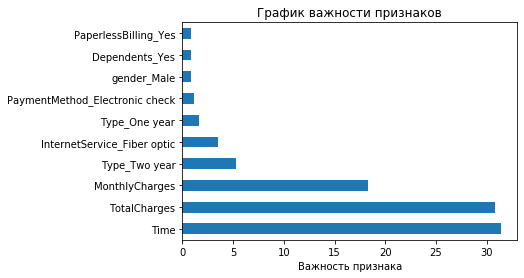

In [33]:
df_importances = pd.Series(model.feature_importances_, index=X_train.columns)
df_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Важность признака')
plt.title('График важности признаков', fontsize=12)
plt.show()

In [34]:
for col in cat_features:
    X_train[col] = X[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [35]:
%%time
gbm = lgb.LGBMClassifier(
                        learning_rate=0.1,
                        n_estimators=150, random_state=1, max_depth=5, num_leaves=50
)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='roc_auc',
        early_stopping_rounds=5, verbose=50)

Training until validation scores don't improve for 5 rounds
[50]	valid_0's binary_logloss: 0.339806
[100]	valid_0's binary_logloss: 0.306756
[150]	valid_0's binary_logloss: 0.294538
Did not meet early stopping. Best iteration is:
[150]	valid_0's binary_logloss: 0.294538
CPU times: user 2min 40s, sys: 1.29 s, total: 2min 41s
Wall time: 2min 42s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=150, n_jobs=-1, num_leaves=50, objective=None,
               random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [36]:
probabilities_test = gbm.predict_proba(X_test, num_iteration=gbm.best_iteration_)
probabilities_one_test = probabilities_test[:, 1]
for threshold in np.arange(0.3, 0.51, 0.05):
    predicted_test = probabilities_one_test > threshold
    roc_auc = roc_auc_score(y_test, predicted_test)
    print("Порог = {:.2f} | ROC-AUC = {:.3f}".format(threshold, roc_auc))

Порог = 0.30 | ROC-AUC = 0.843
Порог = 0.35 | ROC-AUC = 0.843
Порог = 0.40 | ROC-AUC = 0.835
Порог = 0.45 | ROC-AUC = 0.833
Порог = 0.50 | ROC-AUC = 0.824


<a id="conclusions"></a>
## Шаг 3. Выводы.

Самый лучший результат показала модель CatBoostClassifier с подобранными гиперпараметрами и порогом разделения целевой переменной на классы, равным 0.3. 

Показатель целевой метрики ROC-AUC в этом случае составил 0.874, что значительно больше показателя константной модели (0.5). 

Самыми важными признаками, влияющими на вероятность оттока/сохранения клиента, стали время клиента в компании и суммарный объем платежей (чем лояльнее клиент, чем он дольше и больше платит - тем меньше его вероятность ухода).

Таким образом, наша модель неплохо предсказывает склонных к оттоку клиентов, а значит, мы можем эффективно предлагать им скидки с целью сохранения лояльности нашей компании.